<a href="https://colab.research.google.com/github/ArditaHoti/FakeNewsDetection/blob/main/FakeNewsDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:



from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pyspark

In [ ]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, SparkSession
import pyspark.sql.functions as F
from pyspark.sql import *
from pyspark.sql.functions import isnan, when, count, col, udf,  lower, regexp_replace, rand, round, lit, concat
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, StringIndexer, HashingTF, IDF, Word2Vec
from pyspark.sql.types import IntegerType
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [ ]:

#create a SparkConf with the following attributes:
#setAppName: Set application name
#setMaster: Set master URL to connect to
#spark driver memory is a flag that controls the amount of memory to allocate for a driver, which is 1GB by default. It is
#set to 15g to accomadate the text processing and training of models
conf = SparkConf().setAppName('Fake_news_detection').setMaster('local[4]').set('spark.driver.memory', '15g')

#create an entry point using SparkConf: conf
sc = SparkContext(conf=conf)
#SQLcontext is created using sc for realational functionality
sql_context = SQLContext(sc)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


### Data Preprocessing

In [ ]:
#read the real news data
data = sql_context.read.csv('/content/drive/MyDrive/alb-fake-news-corpus.csv', header = True, inferSchema = True)

In [ ]:
data.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+-----------------------------------+-----------------------------+-------------------+--------------------+-------------------------------+---------------+--------------------+--------------------------+---------------+--------------------+-----------------+------------------+---------------------+---------+
|               title|             content|publication_datetime|        facebook_url|        web_page_url|number_of_tokens|number_of_words_without_punctuation|number_of_words_in_upper_case|average_word_length|number_of_characters|number_of_letters_in_upper_case|number_of_verbs|number_of_subjuntive|number_of_imperative_verbs|number_of_nouns|number_of_adjectives|number_of_adverbs|number_of_pronouns|number_of_modal_verbs|fake_news|
+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+-----------

In [ ]:
#Check the length of dataframe
data.count()

3994

In [ ]:
# Collect the count of missing values in each column
missing_counts = [data.where(col(column).isNull()).count() for column in data.columns]
print(missing_counts)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
data.printSchema()

root
 |-- title: string (nullable = true)
 |-- content: string (nullable = true)
 |-- publication_datetime: string (nullable = true)
 |-- facebook_url: string (nullable = true)
 |-- web_page_url: string (nullable = true)
 |-- number_of_tokens: string (nullable = true)
 |-- number_of_words_without_punctuation: string (nullable = true)
 |-- number_of_words_in_upper_case: string (nullable = true)
 |-- average_word_length: string (nullable = true)
 |-- number_of_characters: string (nullable = true)
 |-- number_of_letters_in_upper_case: string (nullable = true)
 |-- number_of_verbs: string (nullable = true)
 |-- number_of_subjuntive: string (nullable = true)
 |-- number_of_imperative_verbs: string (nullable = true)
 |-- number_of_nouns: string (nullable = true)
 |-- number_of_adjectives: string (nullable = true)
 |-- number_of_adverbs: string (nullable = true)
 |-- number_of_pronouns: string (nullable = true)
 |-- number_of_modal_verbs: string (nullable = true)
 |-- fake_news: string (nulla

Show all the values in fake_news column, which will be used as target column

In [ ]:
data.groupBy('fake_news').count().show(80)

+--------------------+-----+
|           fake_news|count|
+--------------------+-----+
|        pos federata|    1|
|  Aragon dhe Navarra|    1|
|         Arben Gashi|    2|
|                 232|    1|
| përkatësisht pol...|    1|
|                   3|    2|
|                  34|    1|
|            kumbullë|    1|
| Vjosa Osmanit dh...|    1|
|                 670|    1|
|                1143|    1|
|                   0|   10|
|               False| 1934|
| bëhu i sinqertë ...|    1|
|                  17|    1|
| shkruante Macgre...|    1|
| ne kemi punuar 1...|    1|
| kanë pasur pakën...|    1|
|                   6|    1|
| gati dyfishë më ...|    1|
| por kësaj here s...|    1|
|https://www.botas...|    1|
| për mbrojtjen e ...|    1|
|                  40|    1|
| anëtarja nga Par...|    3|
|                  25|    1|
|http://www.botaso...|    1|
| vendi më i madh ...|    1|
|                 612|    1|
|                  58|    1|
| ku pas dy shekuj...|    1|
| si vlera të 

Since we are focused in a two labeled classification, whether the article is true or false, we will replace any other values than True to False

In [ ]:
# Replace values other than "False" and "True" with "False"
df_new = data.withColumn("fake_news", when((col("fake_news") == "True") | (col("fake_news") == "False"), col("fake_news")).otherwise("False"))

In [ ]:
#drop rows where fake_news is different from True or False
#df_new = data.filter((F.col('fake_news') == 'True') | (F.col('fake_news') == 'False'))

#view new DataFrame
df_new.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+-----------------------------------+-----------------------------+-------------------+--------------------+-------------------------------+---------------+--------------------+--------------------------+---------------+--------------------+-----------------+------------------+---------------------+---------+
|               title|             content|publication_datetime|        facebook_url|        web_page_url|number_of_tokens|number_of_words_without_punctuation|number_of_words_in_upper_case|average_word_length|number_of_characters|number_of_letters_in_upper_case|number_of_verbs|number_of_subjuntive|number_of_imperative_verbs|number_of_nouns|number_of_adjectives|number_of_adverbs|number_of_pronouns|number_of_modal_verbs|fake_news|
+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+-----------

In [ ]:
df_new.count()

3994

In [ ]:
#3994-3930

In [ ]:
#The preecentage of the rows that are dropped
#64/3994*100


In [ ]:
df_new.groupBy('fake_news').count().show()

+---------+-----+
|fake_news|count|
+---------+-----+
|    False| 1998|
|     True| 1996|
+---------+-----+



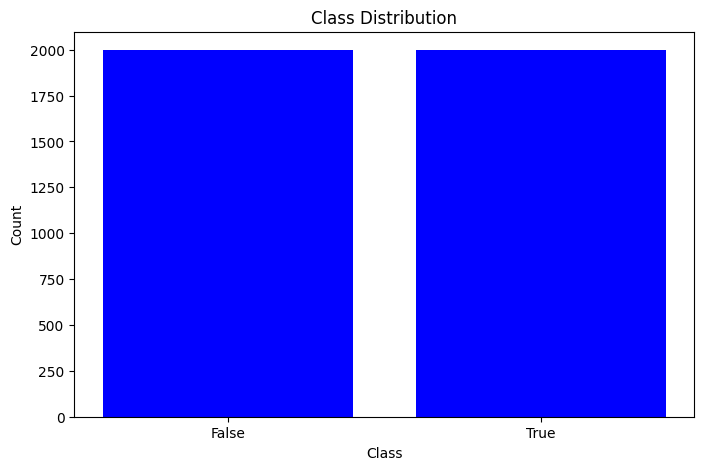

In [ ]:
# Count the number of occurrences for each unique value in the 'fake_news' column
class_counts = df_new.groupBy('fake_news').count().collect()

# Extract class labels and counts for plotting
labels = [str(row['fake_news']) for row in class_counts]
counts = [row['count'] for row in class_counts]

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color='blue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

## **Feature Engineering**

In [ ]:
# Concatenate 'title' and 'content' columns into a new column 'news_article'
df_new = df_new.withColumn('news_article', concat(col('title'), lit(' '), col('content')))



In [ ]:
df_new.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+-----------------------------------+-----------------------------+-------------------+--------------------+-------------------------------+---------------+--------------------+--------------------------+---------------+--------------------+-----------------+------------------+---------------------+---------+--------------------+
|               title|             content|publication_datetime|        facebook_url|        web_page_url|number_of_tokens|number_of_words_without_punctuation|number_of_words_in_upper_case|average_word_length|number_of_characters|number_of_letters_in_upper_case|number_of_verbs|number_of_subjuntive|number_of_imperative_verbs|number_of_nouns|number_of_adjectives|number_of_adverbs|number_of_pronouns|number_of_modal_verbs|fake_news|        news_article|
+--------------------+--------------------+--------------------+--------------------+-------

 ## **Data Cleaning**


In [ ]:

""" delete all the columns except fake_news and news_article
 columns = ["title","content", "publication_datetime", "facebook_url","number_of_tokens","number_of_words_without_punctuation",
           "number_of_words_in_upper_case","average_word_length","number_of_characters","number_of_letters_in_upper_case",
           "number_of_verbs","number_of_subjuntive","number_of_imperative_verbs","number_of_nouns","number_of_adjectives","number_of_modal_verbs","number_of_adverbs",
           "number_of_pronouns","web_page_url"] """
#remove all columns except fake_news and news_article
columns = ["title","content", "publication_datetime", "facebook_url","number_of_tokens","number_of_words_without_punctuation",
           "number_of_words_in_upper_case","average_word_length","number_of_characters","number_of_letters_in_upper_case",
           "number_of_verbs","number_of_subjuntive","number_of_imperative_verbs","number_of_nouns","number_of_adjectives","number_of_modal_verbs","number_of_adverbs",
           "number_of_pronouns","web_page_url"]
df_new = df_new.drop(*columns)

In [ ]:
df_new.show(10)

+---------+--------------------+
|fake_news|        news_article|
+---------+--------------------+
|    False|Studimi gjerman: ...|
|    False|Labinot Tahiri: G...|
|    False|Parashikon Albule...|
|    False|Covid-19 rriti la...|
|    False|Kryeministri Hoti...|
|    False|Hoti: Do t’i dyfi...|
|    False|Prokuroria: I dys...|
|    False|Prokuroria: I dys...|
|    False|Alarmante - Rreth...|
|    False|Numri i të infekt...|
+---------+--------------------+
only showing top 10 rows



In [ ]:
#print the schema of the data
df_new.printSchema()

root
 |-- fake_news: string (nullable = true)
 |-- news_article: string (nullable = true)



**Text Preprocessing using NLP**

The text preprocessing involves the following steps:

1. Tokenize the text into words using RegexTokenizer which is more advanced tokenization based on regular expression matching
2. Removal of Stopwords using StopWordsRemover. Default english stopwords are used to remove unwanted words from the data.
3. Converting text to numerical. Word2Vec is an Estimator which takes sequences of words representing documents, computes distributed vector representation of words and trains a Word2VecModel. The model maps each word to a unique fixed-size vector. The Word2VecModel transforms each document into a vector using the average of all words in the document. The advantage of this representations is that similar words are close in the vector space, which makes generalization to novel patterns easier and model estimation more robust. We moved out from Word2Vec to Hash TFIDF, because negative values created was not accepptable in our NAive Bayes Model.

4. Convert target categorical values into intergers using StringIndexer.  StringIndexer encodes a string column of labels to a column of label indices.



In [ ]:
import string
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param
from pyspark.sql import functions as F
from pyspark.sql.types import StringType
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.ml.pipeline import Transformer


In [ ]:
# Albanian stop words list

""" Resource of Albainan stop words https://betimdrenica.com/2012/05/21/albanian-stop-words.html"""

add_stopwords = ["a","apo","asnjë","asnje","ata","ato","ca","deri","dhe","do","e","i",
"jam","janë","jane","jemi","jeni","ju","juaj","kam","kaq","ke","kemi","kete","këtë",
"më" ,"me","mu","në" ,"ne","nëse","nese""një","nje","nuk","pa","pas","pasi","për","per",
"prej","që","qe","sa","së","se","seç" ,"sec""si","saj","të","te","ti","tek","tij","tonë", "tone",
"tuaj","ty","tyre","unë" ,"une","veç", "vec"]

# Define a custom transformer for removing punctuation from a text column
class PunctuationRemover(Transformer, HasInputCol, HasOutputCol, DefaultParamsReadable, DefaultParamsWritable):
    """
    A PySpark transformer for removing punctuation from a text column.
    """

    def __init__(self, inputCol=None, outputCol=None):
        """
        Initializes a new instance of the PunctuationRemover class.

        Parameters:
        - inputCol: The input column containing text data.
        - outputCol: The output column to store the text with punctuation removed.
        """
        super(PunctuationRemover, self).__init__()
        self.inputCol = inputCol
        self.outputCol = outputCol

    def _transform(self, df):
        """
        Transforms the input DataFrame by removing punctuation from the specified text column.

        Parameters:
        - df: The input DataFrame.

        Returns:
        - Transformed DataFrame with punctuation removed.
        """
        # Create a User-Defined Function (UDF) to remove punctuation
        remove_punct_udf = F.udf(lambda text: text.translate(str.maketrans('', '', string.punctuation)), StringType())

        # Apply the UDF and add a new column with the result
        return df.withColumn(self.outputCol, remove_punct_udf(self.inputCol))


# Punctuation removal
punct_remover = PunctuationRemover(inputCol="news_article", outputCol="text_no_punct")

# Tokenization
tokenizer = RegexTokenizer(inputCol="text_no_punct", outputCol="words", pattern="\\W")

# Stopwords removal
remover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_stopwords)


#Vectorization is a methodology in NLP to map words or phrases from vocabulary to a corresponding vector of real numbers which is used to find word predictions, word similarities/semantics.
# Word to vector
#w2v = Word2Vec(vectorSize=350, minCount=0, inputCol="filtered", outputCol="features")
#TFIDF------------------------
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features")

# Label Indexer
label_stringIdx = StringIndexer(inputCol="fake_news", outputCol="label")


In [ ]:
#pipleline for text pre-processing
pipeline = Pipeline(stages = [punct_remover,tokenizer, remover, hashingTF, idf, label_stringIdx])

#fit the data for the pipeline
pipelineFit = pipeline.fit(df_new)
dataset = pipelineFit.transform(df_new)

# Show 10 random rows from the DataFrame
dataset.orderBy(rand()).show(10)


+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
|fake_news|        news_article|       text_no_punct|               words|            filtered|         rawFeatures|            features|label|
+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
|     True|“Çartet“ Vjosa Os...|“Çartet“ Vjosa Os...|[artet, vjosa, os...|[artet, vjosa, os...|(262144,[253,6636...|(262144,[253,6636...|  1.0|
|    False|Stafi i mediumit ...|Stafi i mediumit ...|[stafi, i, medium...|[stafi, mediumit,...|(262144,[5113,686...|(262144,[5113,686...|  0.0|
|    False|Reja e Shkurte Fe...|Reja e Shkurte Fe...|[reja, e, shkurte...|[reja, shkurte, f...|(262144,[1303,482...|(262144,[1303,482...|  0.0|
|    False|Gjykata Kushtetue...|Gjykata Kushtetue...|[gjykata, kushtet...|[gjykata, kushtet...|(262144,[253,1303...|(262144,[253,1303...

The data is converted to numerical format and below shows the schema of the preprocessed data.

In [ ]:
#check the schema for preprocessed data
dataset.printSchema()

root
 |-- fake_news: string (nullable = true)
 |-- news_article: string (nullable = true)
 |-- text_no_punct: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- rawFeatures: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



**Logistic Regression:**

Description: Logistic Regression is a simple and interpretable model that works well for binary classification tasks.
Advantages: Easy to interpret, computationally efficient, and works well with sparse data.
Use Case: Logistic Regression can be a good starting point for binary classification tasks like fake news detection.

**Random Forest:**

Description: Random Forest is an ensemble learning method that builds multiple decision trees and merges their predictions.
Advantages: Robust, handles high-dimensional data well, and less prone to overfitting compared to individual decision trees.
Use Case: Random Forest can capture complex relationships in the data and is often used for text classification tasks.

**Gradient-Boosted Trees (GBT):**

Description: GBT is an ensemble learning method that builds a series of weak learners (typically decision trees) and combines their predictions.
Advantages: Can capture complex relationships, often more accurate than individual decision trees, and handles imbalanced data well.
Use Case: GBT can provide higher accuracy and capture intricate patterns in your fake news data.

**Support Vector Machine (SVM):**

Description: SVM is a powerful classification algorithm that finds the hyperplane that best separates the classes in the feature space.
Advantages: Effective in high-dimensional spaces, versatile due to different kernel functions, and works well for both linear and non-linear data.
Use Case: SVM can be applied to fake news detection by transforming text data into a high-dimensional feature space.

**5. Function for Evaluation Metrics**

This project is implmented using five machine learning algorithms. The performance of the models are evaluated confusion matrix, F1 score and Area under the curve. The model with less False positives and false negatives, high F1 score and AUC will be considered as a better model for fake news detection. Matplotlib and Numpy is used to plot the confusion matrix.


In [ ]:
#function to calculate the evaluation metrics
def evalualte_metrics(predictions):
    '''Accuracy'''
    #label = predictions.select(['prediction', 'label'])
    evaluator = MulticlassClassificationEvaluator(labelCol = "label", predictionCol = "prediction", metricName = "accuracy")
    accuracy = evaluator.evaluate(predictions)*100

    #select prediction and label columns to calculate metric values
    results = predictions.select(['prediction', 'label'])
    #convert the results to rdd to get predictions and labels
    predictionAndLabels = results.rdd


    '''Area under the curve'''
    binary_evaluator = BinaryClassificationMetrics(predictionAndLabels)
    auc = binary_evaluator.areaUnderROC

    '''Classification report'''
    #create a multiclassmetrics instance
    metrics = MulticlassMetrics(predictionAndLabels)

    #compute Recall with respect to Real and fake news data
    real_recall = metrics.recall(0.0)
    fake_recall = metrics.recall(1.0)

    #compute Precision with respect to Real and fake news data
    real_precision = metrics.precision(0.0)
    fake_precision = metrics.precision(1.0)

    #compute F1 Score with respect to Real and fake news data
    real_f1 = metrics.fMeasure(0.0)
    fake_f1 = metrics.fMeasure(1.0)

    #create a classificaiton report for the model
    real = Row(News = 'Real', recall = real_recall, precision = real_precision, f1_score = real_f1)
    fake = Row(News = 'Fake', recall = fake_recall, precision = fake_precision, f1_score = fake_f1)

    classification_report = [real, fake]
    classification_report_df = sql_context.createDataFrame(classification_report)

    '''Confusion matrix'''
    conf_matrix = metrics.confusionMatrix().toArray()

    return accuracy, auc, classification_report_df, conf_matrix

In [ ]:
#function for confusion matrix
def plot_confusion_matrix(cm, target_names, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center')

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

**6. Modelling**

This section implements different algorithms to predict the fake news. Initially the data is split into train and test in the ratio 70:30 using randomSplit function.

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics


In [ ]:
#split the data
train, test = dataset.randomSplit([0.8, 0.2])


In [ ]:
#check the train and test data count
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 3204
Test Dataset Count: 790


## Logistic Regression Model

In [ ]:
lr = LogisticRegression(labelCol="label", featuresCol="features")


In [ ]:
#Create a parameter grid for tuning the model
lrparamGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.1, 0.5, 1.0, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10, 20, 50])
             .build())

In [ ]:
# Create 5-fold CrossValidator
"""lrcv = CrossValidator(estimator = lr,
                    estimatorParamMaps = lrparamGrid,
                    evaluator = evalualte_metrics(lr),
                    numFolds = 5)"""

'lrcv = CrossValidator(estimator = lr,\n                    estimatorParamMaps = lrparamGrid,\n                    evaluator = evalualte_metrics(lr),\n                    numFolds = 5)'

In [ ]:

#Fit the model to the data
lrModel = lr.fit(train)
lr_predictions = lrModel.transform(test)
print(lrModel)


LogisticRegressionModel: uid=LogisticRegression_35c9cbe3478c, numClasses=2, numFeatures=262144


In [ ]:
#calculate the evaluation metrics of LogisticRegression model
lr_accuracy, lr_auc, lr_classification_report_df, lr_conf_matrix = evalualte_metrics(lr_predictions)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
#print the auuracy and area under the curve
print("Logistic Regression accuracy is: {:0.2f}".format(lr_accuracy))
print("Logistic Regression AUC is: {:0.2f}".format(lr_auc))

Logistic Regression accuracy is: 79.75
Logistic Regression AUC is: 0.80


In [ ]:
#display the classification report
lr_classification_report_df.show()

+----+------------------+------------------+------------------+
|News|            recall|         precision|          f1_score|
+----+------------------+------------------+------------------+
|Real|0.7135802469135802|0.8678678678678678|0.7831978319783197|
|Fake|0.8857142857142857|0.7461706783369803|0.8099762470308789|
+----+------------------+------------------+------------------+



In [ ]:
#print the confusion matrix
print("Confusion Matrix")
print(lr_conf_matrix)

Confusion Matrix
[[289. 116.]
 [ 44. 341.]]


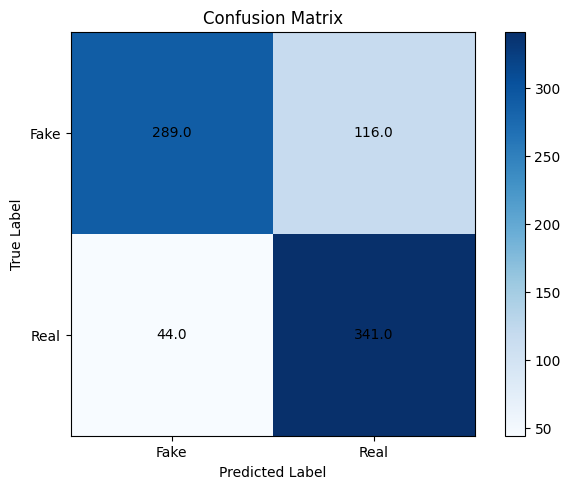

In [ ]:
#plot confusion matrix
plot_confusion_matrix(lr_conf_matrix,["Fake","Real"])

## Random Forest Model

In [ ]:
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [ ]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

In [ ]:
#Fit the model to the data
rfModel = rf.fit(train)
rf_predictions = rfModel.transform(test)
print(rfModel)

RandomForestClassificationModel: uid=RandomForestClassifier_2072fc35257c, numTrees=20, numClasses=2, numFeatures=262144


In [ ]:
#calculate the evaluation metrics of LogisticRegression model
rf_accuracy, rf_auc, rf_classification_report_df, rf_conf_matrix = evalualte_metrics(rf_predictions)

In [ ]:
#print the auuracy and area under the curve
print("Random Forest accuracy is: {:0.2f}".format(rf_accuracy))
print("Random Forest AUC is: {:0.2f}".format(rf_auc))

Random Forest accuracy is: 77.59
Random Forest AUC is: 0.78


In [ ]:
#display the classification report
rf_classification_report_df.show()

+----+------------------+------------------+------------------+
|News|            recall|         precision|          f1_score|
+----+------------------+------------------+------------------+
|Real|0.7135802469135802|0.8257142857142857|0.7655629139072848|
|Fake|0.8415584415584415|0.7363636363636363|0.7854545454545455|
+----+------------------+------------------+------------------+



In [ ]:
#print the confusion matrix
print("Confusion Matrix")
print(rf_conf_matrix)

Confusion Matrix
[[289. 116.]
 [ 61. 324.]]


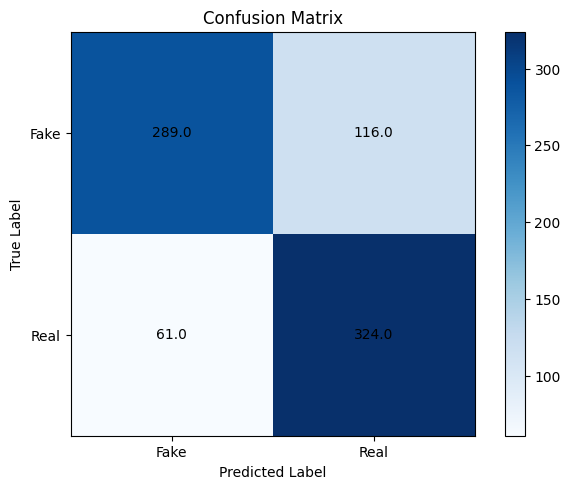

In [ ]:
#plot confusion matrix
plot_confusion_matrix(rf_conf_matrix,["Fake","Real"])

## **Decision Tree Model**


In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
#define decision tree
dt = DecisionTreeClassifier(labelCol="label", featuresCol = "features")

#train the model and predict on test data
dtModel = dt.fit(train)
dt_predictions = dtModel.transform(test)

In [ ]:
#calculate the evaluation metrics of decision tree model
dt_accuracy, dt_auc, dt_classification_report_df, dt_conf_matrix = evalualte_metrics(dt_predictions)

In [ ]:
#print the auuracy and area under the curve
print("Decision Tree accuracy is: {:0.2f}".format(dt_accuracy))
print("Decision Tree AUC is: {:0.2f}".format(dt_auc))

Decision Tree accuracy is: 80.38
Decision Tree AUC is: 0.80


In [ ]:
#display the classification report
dt_classification_report_df.show()

+----+------------------+------------------+------------------+
|News|            recall|         precision|          f1_score|
+----+------------------+------------------+------------------+
|Real|0.9975308641975309|0.7240143369175627|0.8390446521287642|
|Fake|               0.6|0.9956896551724138|0.7487844408427876|
+----+------------------+------------------+------------------+



In [ ]:
#print the confusion matrix
print("Confusion Matrix")
print(dt_conf_matrix)

Confusion Matrix
[[404.   1.]
 [154. 231.]]


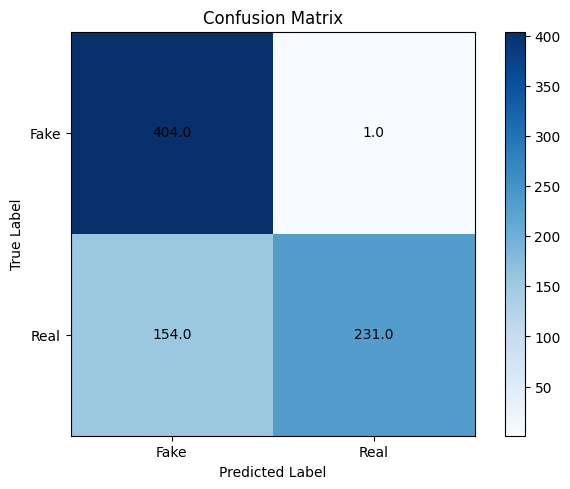

In [ ]:
#plot confusion matrix
plot_confusion_matrix(dt_conf_matrix,["Fake","Real"])

## Naive Bayes

In [ ]:
from pyspark.ml.classification import NaiveBayes

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

In [ ]:
nb = NaiveBayes(labelCol="label", featuresCol="features")

In [ ]:
#train the model and predict on test data
nbModel = nb.fit(train)
nb_predictions = nbModel.transform(test)

In [ ]:
#calculate the evaluation metrics of decision tree model
nb_accuracy, nb_auc, nb_classification_report_df, nb_conf_matrix = evalualte_metrics(nb_predictions)

In [ ]:
#print the auuracy and area under the curve
print("Naive Bayes accuracy is: {:0.2f}".format(nb_accuracy))
print("Naive Bayes AUC is: {:0.2f}".format(nb_auc))

Naive Bayes accuracy is: 83.04
Naive Bayes AUC is: 0.83


In [ ]:
#display the classification report
nb_classification_report_df.show()

+----+------------------+------------------+------------------+
|News|            recall|         precision|          f1_score|
+----+------------------+------------------+------------------+
|Real|0.8765432098765432|0.8086560364464692|0.8412322274881516|
|Fake|0.7818181818181819|0.8575498575498576|0.8179347826086957|
+----+------------------+------------------+------------------+



In [ ]:
#print the confusion matrix
print("Confusion Matrix")
print(nb_conf_matrix)

Confusion Matrix
[[355.  50.]
 [ 84. 301.]]


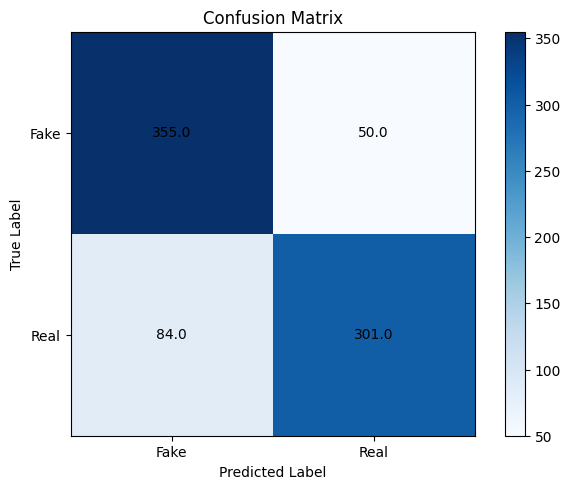

In [ ]:
#plot confusion matrix
plot_confusion_matrix(nb_conf_matrix,["Fake","Real"])

#Gradient-Boosted Tree

In [ ]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [ ]:
gb = GBTClassifier(labelCol="label", featuresCol="features")

In [ ]:
#train the model and predict on test data
gbModel = gb.fit(train)
gb_predictions = gbModel.transform(test)

In [ ]:
#calculate the evaluation metrics of decision tree model
gb_accuracy, gb_auc, gb_classification_report_df, gb_conf_matrix = evalualte_metrics(gb_predictions)

In [ ]:
#print the auuracy and area under the curve
print("Gardient Booster accuracy is: {:0.2f}".format(gb_accuracy))
print("Gardient Booster AUC is: {:0.2f}".format(gb_auc))

Gardient Booster accuracy is: 85.70
Gardient Booster AUC is: 0.86


In [ ]:
#display the classification report
gb_classification_report_df.show()

+----+------------------+------------------+------------------+
|News|            recall|         precision|          f1_score|
+----+------------------+------------------+------------------+
|Real|0.9185185185185185|0.8230088495575221| 0.868144690781797|
|Fake|0.7922077922077922|0.9023668639053254|0.8437067773167359|
+----+------------------+------------------+------------------+



In [ ]:
#print the confusion matrix
print("Confusion Matrix")
print(gb_conf_matrix)

Confusion Matrix
[[372.  33.]
 [ 80. 305.]]


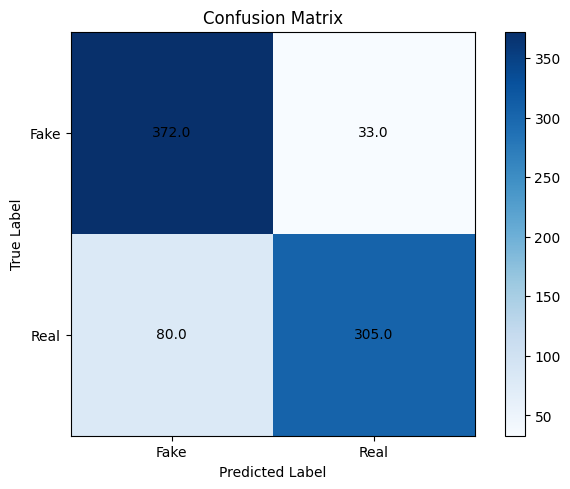

In [ ]:
#plot confusion matrix
plot_confusion_matrix(gb_conf_matrix,["Fake","Real"])

###. **Linear SVC - linear support vector machine classifier**

In [ ]:

from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Train the model
classifier = LinearSVC(maxIter=1000)
model = classifier.fit(train)

# Make predictions
lsvc_predictions = model.transform(test)

# Evaluate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
#calculate the evaluation metrics of decision tree model
lsvc_accuracy, lsvc_auc, lsvc_classification_report_df, lsvc_conf_matrix = evalualte_metrics(lsvc_predictions)
#print the auuracy and area under the curve
print("Linear SVC accuracy is: {:0.2f}".format(lsvc_accuracy))
print("Linear SVC AUC is: {:0.2f}".format(lsvc_auc))


Linear SVC accuracy is: 86.58
Linear SVC AUC is: 0.87


In [ ]:
#display the classification report
lsvc_classification_report_df.show()

+----+------------------+------------------+------------------+
|News|            recall|         precision|          f1_score|
+----+------------------+------------------+------------------+
|Real|0.8493827160493828| 0.884318766066838|0.8664987405541562|
|Fake|0.8831168831168831|0.8478802992518704|0.8651399491094148|
+----+------------------+------------------+------------------+



In [ ]:
# Save the model using PySpark's save method
model.save("model_path")

# Load the model in Flask
from pyspark.ml.classification import LinearSVCModel

# Load the model from the saved directory
model = LinearSVCModel.load("model_path")

# Save the pipeline using PySpark's save method
pipelineFit.save("pipeline_path")

In [ ]:
!pip install flask
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip


--2024-04-18 04:50:51--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.237.133.81, 54.161.241.46, 52.202.168.65, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.237.133.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.28M  5.59MB/s    in 2.4s    

2024-04-18 04:50:54 (5.59 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13921656/13921656]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


Created a Flask application to serve our model

In [ ]:
from flask import Flask, request, jsonify, render_template
from pyspark.ml.classification import LinearSVCModel

app = Flask(__name__)

# Load the PySpark model
model = LinearSVCModel.load("model_path")


In [ ]:
# Default page of our web-app
@app.route('/')
def home():
    #return render_template('index.html')
    return "Hello World"

In [ ]:
if __name__ == '__main__':
    app.run(host='0.0.0.0', debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


In [ ]:
@app.route('/predict', methods=['POST'])
def predict():
    # Get input data from client
    data = request.json

    # Preprocess input data using the loaded pipeline
    processed_data = pipeline.transform(json.dumps(data))

    # Make predictions using the loaded model
    prediction = model.transform(processed_data)

    # Extract prediction result
    prediction_result = prediction.select('prediction').collect()[0][0]

    # Convert prediction to human-readable format
    prediction_label = "Fake" if prediction_result == 1 else "Real"

    # Return prediction result to client
    return jsonify({'prediction': prediction_label})